# Part 1: Getting started

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
os.environ['LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:'

## Fetch the jet tagging dataset from Open ML

In [4]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### Let's print some information about the dataset
Print the feature names and the dataset shape

In [5]:
print(data['feature_names'])
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
(830000, 16) (830000,)
      zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0 -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1 -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2 -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3 -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4 -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   

   d2_b1_mmdt  d2_b2_mmdt  d2_a1_b1_mmdt  d2_a1_b2_mmdt  m2_b1_mmdt  \
0    1.769445    2.123898       1.769445       0.308185    0.135687   
1    2.038834    2.563099       2.038834       0.211886    0.063729   
2    1.269254    1.346238       1.269254       0.246488    0.115636   
3    0.966505  

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a "One Hot" encoding for the training.
Then, split the dataset into training and validation sets

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y[:5])

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [7]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

In [8]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test[:100])
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test[:100])
np.save('classes.npy', le.classes_)

## Now construct a model
We'll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use `relu` activation.
Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

In [34]:
model = Sequential()
#model.add(Dense(64, name='dense_1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
#model.add(Activation(activation='relu', name='relu_1'))
model.add(Dense(64, name='dense_1', kernel_initializer='lecun_uniform', bias_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), input_shape=(16,)))
model.add(Activation(activation='relu', name='relu_1'))
#model.add(Activation(activation='softmax', name='softmax_1'))

## Train the model
We'll use Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_1'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model.

In [35]:
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [337]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=10,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/10


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 5) and (None, 64) are incompatible


## Check performance
Check the accuracy and make a ROC curve

In [467]:
X_fake = np.array(X_test)
X_fake = np.concatenate((X_fake, X_fake,  X_fake, X_fake), axis=1)
np.save('X_test.npy', X_fake[:100])
#print(X_fake[0])

In [468]:
model.predict(X_fake)

5188/5188 [==============================] - 10s 2ms/step


array([[0.        , 1.3946744 , 0.7703638 , ..., 0.49908486, 0.        ,
        1.1765906 ],
       [0.6751019 , 1.669952  , 1.86177   , ..., 0.        , 0.        ,
        0.9233258 ],
       [0.        , 0.        , 2.2465544 , ..., 1.2059479 , 1.0320828 ,
        0.        ],
       ...,
       [0.        , 0.01751199, 0.        , ..., 0.07387672, 0.        ,
        0.19162321],
       [0.        , 0.        , 0.6830518 , ..., 0.16803531, 1.1171372 ,
        0.        ],
       [0.649094  , 0.        , 0.54856193, ..., 0.3125981 , 0.33029312,
        0.36036015]], dtype=float32)

In [19]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

5188/5188 [==============================] - 8s 1ms/step
Accuracy: 0.016512048192771085


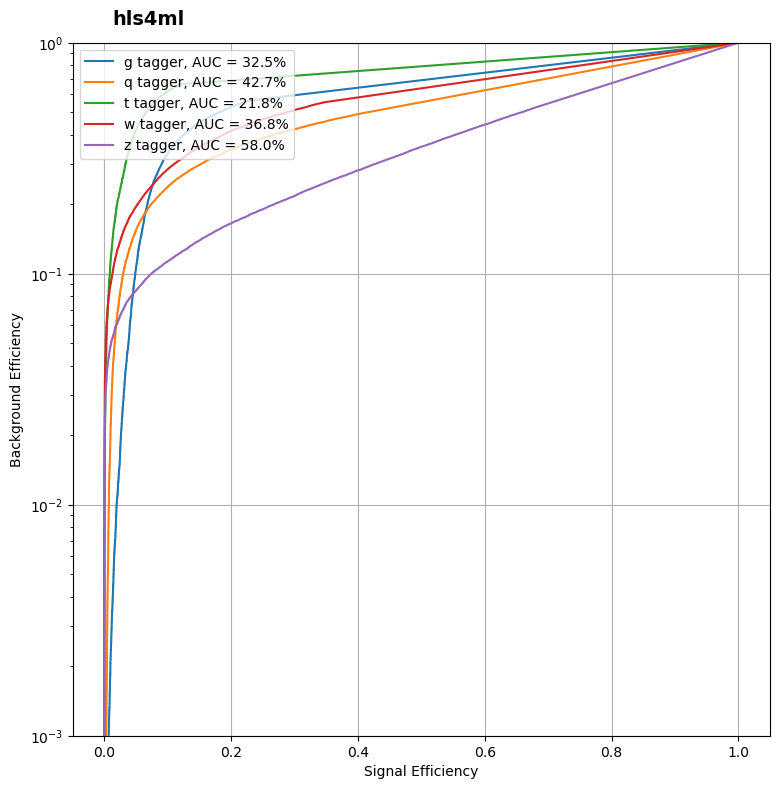

In [26]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(np.array(X_test))
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

### Make an hls4ml config & model
The hls4ml Neural Network inference library is controlled through a configuration dictionary.
In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [42]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='VivadoAccelerator')
print("-----------------------------------")
print("Configuration")

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Strategy'] = 'Latency'
    #config['LayerName'][layer]['PipelineStyle'] = 'DataFlow'
    #config['LayerName'][layer]['StoreWeightsInBram'] = True

config['Model']['ReuseFactor'] = 8
config['LayerName']['dense_1']['ReuseFactor'] = 8
#config['LayerName']['dense_2']['ReuseFactor'] = 8
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, input_data_tb='X_test.npy', output_data_tb='y_hls.npy', output_dir='model_1/hls4ml_prj', 
    backend='VivadoAccelerator', board='pynq-z2', io_type='io_parallel'
)

Interpreting Sequential
Topology:
Layer name: dense_1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu_1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       8
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  dense_1_input
    Trace:           False
    Precision
      result:        fixed<16,6>
    Strategy:        Latency
  dense_1
    Trace:           False
    Precision
      result:        fixed<16,6>
      weight:        fixed<16,6>
      bias:          fixed<16,6>
      accum:         fixed<16,6>
    ReuseFactor:     8
    Strategy:        Latency
  dense_1_linear
    Trace:           False
    Precision
      result:        fixed<16,6>
      table:     

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

In [43]:
w = hls4ml.writer.vivado_writer.VivadoWriter()
w.write_test_bench(hls_model)

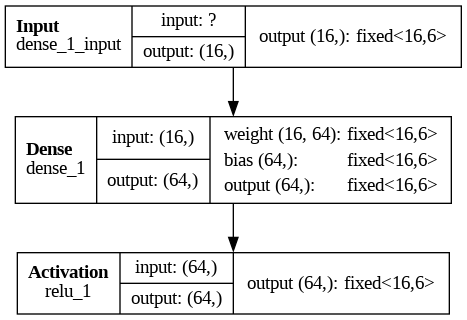

In [44]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

## Compile, predict
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.

In [45]:
hls_model.compile()

Writing HLS project
Done


In [477]:
## FAKE (64 inputs)
X_fake = np.ascontiguousarray(X_fake)
y_hls = hls_model.predict(X_fake[:100])
np.save('y_hls.npy', y_hls)

In [40]:
## REAL (16 inputs)
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test[:100])
np.save('y_hls.npy', y_hls)

## Compare
That was easy! Now let's see how the performance compares to Keras:

In [531]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, le.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

Keras  Accuracy: 0.008427710843373494


ValueError: Found input variables with inconsistent numbers of samples: [166000, 100]

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [49]:
hls_model.build(csim=False, cosim=False, synth=True, vsynth=True, validation=False, export=False, bitfile=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host '35bea003a40e' (Linux_x86_64 version 5.15.133.1-microsoft-standard-WSL2) on Thu Jan 11 16:38:42 UTC 2024
INFO: [HLS 200-10] In directory '/home/jovyan/hls4ml-tutorial/model_1/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/jovyan/hls4ml-tutorial/model_1/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
IN

{'CSimResults': [['{', 'data:', '0.546875,', 'last:', '0', '}'],
  ['{', 'data:', '0.87207,', 'last:', '0', '}'],
  ['{', 'data:', '1.03027,', 'last:', '0', '}'],
  ['{', 'data:', '0.415039,', 'last:', '0', '}'],
  ['{', 'data:', '1.03906,', 'last:', '0', '}'],
  ['{', 'data:', '0.841797,', 'last:', '0', '}'],
  ['{', 'data:', '1.09668,', 'last:', '0', '}'],
  ['{', 'data:', '0.584961,', 'last:', '0', '}'],
  ['{', 'data:', '0.530273,', 'last:', '0', '}'],
  ['{', 'data:', '0.631836,', 'last:', '0', '}'],
  ['{', 'data:', '0.53125,', 'last:', '0', '}'],
  ['{', 'data:', '0.381836,', 'last:', '0', '}'],
  ['{', 'data:', '1.19141,', 'last:', '0', '}'],
  ['{', 'data:', '0.0380859,', 'last:', '0', '}'],
  ['{', 'data:', '0.913086,', 'last:', '0', '}'],
  ['{', 'data:', '0.700195,', 'last:', '0', '}'],
  ['{', 'data:', '0.457031,', 'last:', '0', '}'],
  ['{', 'data:', '0.855469,', 'last:', '0', '}'],
  ['{', 'data:', '0.363281,', 'last:', '0', '}'],
  ['{', 'data:', '0.738281,', 'last:', '

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [28]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Compiling ../../../../firmware/myproject_axi.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Quantized predictions
{ data: 0.546875, last: 0 }
 { data: 0.87207, last: 0 }
 { data: 1.03027, last: 0 }
 { data: 0.415039, last: 0 }
 { data: 1.03906, last: 0 }
 { data: 0.841797, last: 0 }
 { dat

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)